<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/TestMask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Mounted at /content/gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source
!ls

Cloning into 'teambrainiac'...
remote: Enumerating objects: 651, done.
remote: Counting objects: 100% (651/651), done.
remote: Compressing objects: 100% (467/467), done.
remote: Total 651 (delta 398), reused 343 (delta 168), pack-reused 0
Receiving objects: 100% (651/651), 68.39 MiB | 12.31 MiB/s, done.
Resolving deltas: 100% (398/398), done.
/content/teambrainiac/source
AccuracyMeasures.ipynb	  models
analysis.py		  process.py
cross_validation.py	  SingleSubjectSVM.ipynb
data			  SubjectVisualization_Models_ZNORM.ipynb
DL			  SVM_Group_Adolescent_Whole_brain.ipynb
Explore_data.ipynb	  SVM_Group_YA_Whole_brain.ipynb
explore.py		  train.py
Group_All_MASK_SVM.ipynb  utils.py
helper			  VisualizationPlayground.ipynb
Images			  Visualize_Data.ipynb
__init__.py


In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


In [47]:
# Import libraries
!pip install boto3 nilearn nibabel
import nibabel as nib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, auc, recall_score, precision_score,roc_curve,f1_score
import pickle
from utils import data_to_nib, load_mat, open_pickle, access_load_data, save_data, create_mask, labels_mask_binary, masking_data, masked_data_n_labels
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import numpy as np
import random
from nilearn.signal import clean
from utils import *
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
#open path dictionary file to get subject ids
path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(path)
path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(path)
subject_ids = data_path_dict['subject_ID']
subj_paths = data_path_dict['subject_data']
label_data_path = data_path_dict['labels'][0]
label_type = 'rt_labels'
mask_labels_indices, binary_labels = labels_mask_binary(label_data_path, label_type)

In [13]:
# mask_path = "/content/drive/My Drive/data/mask_flat.mat"
# mask = scipy.io.loadmat(mask_path)
# mask_flat = mask['mask_flat']

In [19]:
# mask_final = mask_flat.reshape(1,-1)
# mask_final = mask_final[0]
# ind = np.where(mask_final==1)
# ind

(array([ 68755,  68756,  68757, ..., 566712, 566713, 566714]),)

In [22]:
# np_compatible_mask = np.ma.make_mask(mask_final)

In [183]:
mask_data_filepath = data_path_dict['mask_data'][0]
mask_type_dict = access_load_data(mask_data_filepath, True)
np_array_mask = mask_type_dict['mask']
np_compatible_mask = np.ma.make_mask(np_array_mask).reshape(79*95*79,order='F')

In [133]:
# test_reshape = np_array_mask.reshape(79*95*79,order='F')

In [184]:
# mask_test = np.ma.make_mask(test_reshape)
# mask_test.shape
ind = np.where(np_compatible_mask==True)
ind

(array([ 68755,  68756,  68757, ..., 566712, 566713, 566714]),)

In [185]:
from utils import *
import numpy as np
from sklearn.preprocessing import StandardScaler
def scale_data_single_subj(sub_data,sub_labels, runs_train,runs_test,norm):
  """
    data         : (1 subject data, keys as subject ID for frmi data or labels)
    runs_train   : tuple , (which run are we using for the training data)
    runs_test    : tuple, (which run are we using for the test data)
    norm         : string, ("RUNS": normalizing separately on each run;
                            "SUBJECT": Normalizing separately by each subject)
    returns      : nd.arrays, Concatenated X data of (time points, x*y*z) x = 79, y = 95, z = 75
                   and Concatenated y labels of (time points,)
    """

    # train and labels
  X = []
  y = []
  ##val and labels
  Xv = []
  yv = []
  # TEST and labels
  Xt = []
  yt = []
  if len(runs_train)>1:
      for run in runs_train:
        X.append(sub_data[run])
        y.append(sub_labels[run])
      
      X = np.concatenate(np.array(X))
      y = np.concatenate(np.array(y))
  else:
      X = sub_data[runs_train[0]-1]
      y = sub_labels[runs_train[0]-1]
  if len(runs_test)> 1:
      Xv = sub_data[runs_test[0]-1]
      yv = sub_labels[runs_test[0]-1]
      Xt = sub_data[runs_test[1]-1]
      yt = sub_labels[runs_test[1]-1]
  else:
      Xt = sub_data[runs_test[0]-1]
      yt = sub_labels[runs_test[0]-1]
  if norm == "RUNS":
      scalar = StandardScaler()
      X = scalar.fit_transform(X)

      scalarT = StandardScaler()
      Xt = scalarT.fit_transform(Xt)
      if len(Xv)>0:
        Xv = scalarT.fit_transform(Xv)
  elif norm == "SUBJECT":
      #print(f"Normalizing Each Subject Data for group {group_sub_ids}")
      scalar = StandardScaler().fit(X)
      X = scalar.transform(X)
      

      Xt = scalar.transform(Xt)
      if len(Xv)>0:
        Xv = scalar.transform(Xv)
  else:
      print('Not doing standardization')      
  return X, y, Xt, yt, Xv, yv

In [189]:
def load_subject_data(idx,dopsc):
  mat_path = subj_paths[idx]
  sub_id = subject_ids[idx]
  print(mat_path,idx,sub_id)
  data = access_load_data(mat_path,True)
  user_data_dict = {}
  user_data_dict[sub_id], bi_lb = masking_data(data, np_compatible_mask, mask_labels_indices, binary_labels, dopsc)
  user_data_dict[f"{sub_id}_{label_type}"] = bi_lb
  return user_data_dict, sub_id
#mask_labels_indices, binary_labels = labels_mask_binary(label_data_path, label_type)


In [190]:
from sklearn.metrics import accuracy_score
def run_single_subject_svm(sub_data,sub_labels,runs_train,runs_test,norm="none",do_cv=False):
  #if norm!="none":
  X_train, y_train, X_test, y_test, X_val, y_val = scale_data_single_subj(sub_data,sub_labels,runs_train,runs_test,norm)
  # else:
  #   X_train = sub_data[1]
  #   y_train = sub_labels[1]
  #   X_val = sub_data[2]
  #   y_val = sub_labels[2]
  #   X_test = sub_data[3]
  #   y_test = sub_labels[3]
  if do_cv:
    c_params = {'C':[0.7, 1, 5, 10],  'random_state':[111,222],'kernel':['linear', 'rbf']}
    svc = SVC()
    clf = GridSearchCV(svc, c_params)
    clf.fit(X_train, y_train)
    if len(X_val)>0:
      y_val_predicts = clf.predict(X_val)
      val_acc = accuracy_score(y_val,y_val_predicts)
    else:
      val_acc = 0
    y_test_predicts = clf.predict(X_test)
    test_acc = accuracy_score(y_test,y_test_predicts)
    return clf,val_acc,test_acc
  else:
    clf = SVC(C=10)
    clf.fit(X_train,y_train)

  return clf,X_train,y_train,X_test,y_test,X_val,y_val

In [191]:

def run_subject_model(subject_ids, runs_train,runs_test,do_psc=True,norm='none'):
  single_model_path={}
  for idx in range(len(subject_ids)):
    model_dict = {}
    user_data_dict, sub_id = load_subject_data(idx,do_psc)
    sub_data = user_data_dict[sub_id]
    sub_labels = user_data_dict[f"{sub_id}_rt_labels"]
    clf,X_train, y_train, X_test, y_test, X_val, y_val = run_single_subject_svm(sub_data,sub_labels,runs_train,runs_test,norm)
    model_dict[sub_id] = {}
    model_dict[sub_id]['model'] = clf
    model_dict[sub_id]['X_train'] = X_train
    model_dict[sub_id]['y_train'] = y_train
    model_dict[sub_id]['X_test'] = X_test
    model_dict[sub_id]['y_test'] = y_test
    if len(X_val)>0:
      model_dict[sub_id]['X_val'] = X_val
      model_dict[sub_id]['y_val'] = y_val
    single_model_path[sub_id] = f'models/single/one_run_model_znorm_{sub_id}.pkl'
    # object_name = f"models/single/one_run_model_znorm_{sub_id}.pkl"
    # upload = s3_upload(model_dict,object_name,"pickle")
  return single_model_path, model_dict,user_data_dict

In [192]:
file_name_dict,model_dict,user_data_dict = run_subject_model([subject_ids[0]],(2,),(3,4),do_psc=False,norm='RUNS')


svm_data/10004_08693/svm_subj_vecs.mat 0 10004_08693


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


In [193]:
subj = subject_ids[0]
subj_acc = []

clf = model_dict[subj]['model']
X_train = model_dict[subj]['X_train']
y_train = model_dict[subj]['y_train']
X_test = model_dict[subj]['X_test'] 
y_test = model_dict[subj]['y_test']
if 'X_val' in model_dict[subj].keys():
  X_val = model_dict[subj]['X_val']
  y_val = model_dict[subj]['y_val']
  y_val_predicts = clf.predict(X_val)
  val_acc = accuracy_score(y_val,y_val_predicts)
  fpr,tpr,thresholds = roc_curve(y_val,y_val_predicts)
  val_auc = auc(fpr,tpr)
  val_precision = precision_score(y_val,y_val_predicts)
  val_recall = recall_score(y_val,y_val_predicts)
  val_f1 = f1_score(y_val,y_val_predicts)
else:
  y_val_predicts = 0
  val_acc = 0
train_predicts = clf.predict(X_train) 
y_test_predicts = clf.predict(X_test)
tr_acc = accuracy_score(y_train,train_predicts)   
test_acc = accuracy_score(y_test,y_test_predicts)
fpr,tpr,thresholds = roc_curve(y_test,y_test_predicts)
test_auc = auc(fpr,tpr)
test_precision = precision_score(y_test,y_test_predicts)
test_recall = recall_score(y_test,y_test_predicts)
test_f1 = f1_score(y_test,y_test_predicts)
subj_list = [subj,tr_acc,val_acc,val_auc,val_precision,val_recall,val_f1, test_acc,test_auc,test_precision,test_recall,test_f1,'RUNS','PSCNORM']
subj_acc.append(subj_list)

In [194]:
subj_acc

[['10004_08693',
  1.0,
  0.7023809523809523,
  0.7023809523809523,
  0.6976744186046512,
  0.7142857142857143,
  0.7058823529411765,
  0.8571428571428571,
  0.8571428571428571,
  0.8409090909090909,
  0.8809523809523809,
  0.8604651162790699,
  'RUNS',
  'PSCNORM']]

In [195]:

#affine_image = nib.load('/content/drive/My Drive/data/w3rtprun_01.nii')
affine_image = access_load_data('w3rtprun_01.nii',False)
t1_image = access_load_data('single_subj_T1_resampled.nii',False)

In [141]:

clf = model_dict[subj]['model']
X_train = model_dict[subj]['X_train']
y_train = model_dict[subj]['y_train']
alphas = np.zeros((84))
alphas[clf.support_] = clf.dual_coef_
alphas = alphas.reshape(1,-1)
bmap = np.dot(alphas,X_train)
bmap2 = np.zeros((79,95,79))
bmap2 = bmap2.reshape(79*95*79)
bmap2[ind] = bmap
bmap2_3d = bmap2.reshape(79,95,79,order='F')

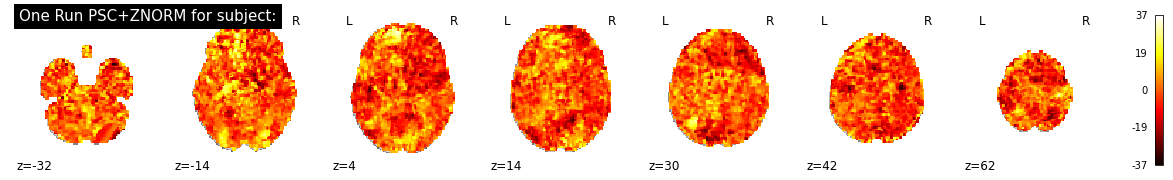

In [199]:
from nilearn import plotting, image

bmap3 = nib.Nifti1Image(bmap2_3d,affine=affine_image.affine,header=affine_image.header)
display = plotting.plot_stat_map(bmap3, 
                                 colorbar=True, cmap='hot', display_mode='z',
                                 title=f"One Run PSC+ZNORM for subject:")

In [132]:
nib.save(bmap3,'/content/drive/My Drive/data/bmap3_new.nii')

In [76]:
import scipy.io
mat_file_dict = {}
mat_file_dict['X_train']=X_train
mat_file_dict['y_train']=y_train
mat_file_dict['alphas']=alphas
mat_file_dict['bmap']=bmap
mat_file_dict['bmap2']=bmap2
mat_file_dict['supports'] = clf.support_
mat_file_dict['dual_coef'] = clf.dual_coef_
#mat_file_dict['bmap3']=bmap3

scipy.io.savemat('/content/drive/My Drive/data/test_3.mat', mat_file_dict)